In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
train = np.load("FireEvac_train_set.npy")
test = np.load("FireEvac_test_set.npy")

train_unsqueeze = np.expand_dims(train, -1).astype("float32")           # Concatenate train and test sets
test_unsqueeze = np.expand_dims(test, -1).astype("float32")             # Normalize
fire_train = -1+2*(train_unsqueeze - np.min(train_unsqueeze)) / (np.max(train_unsqueeze) - np.min(train_unsqueeze))
fire_test = -1+2*(test_unsqueeze - np.min(test_unsqueeze)) / (np.max(test_unsqueeze) - np.min(test_unsqueeze))

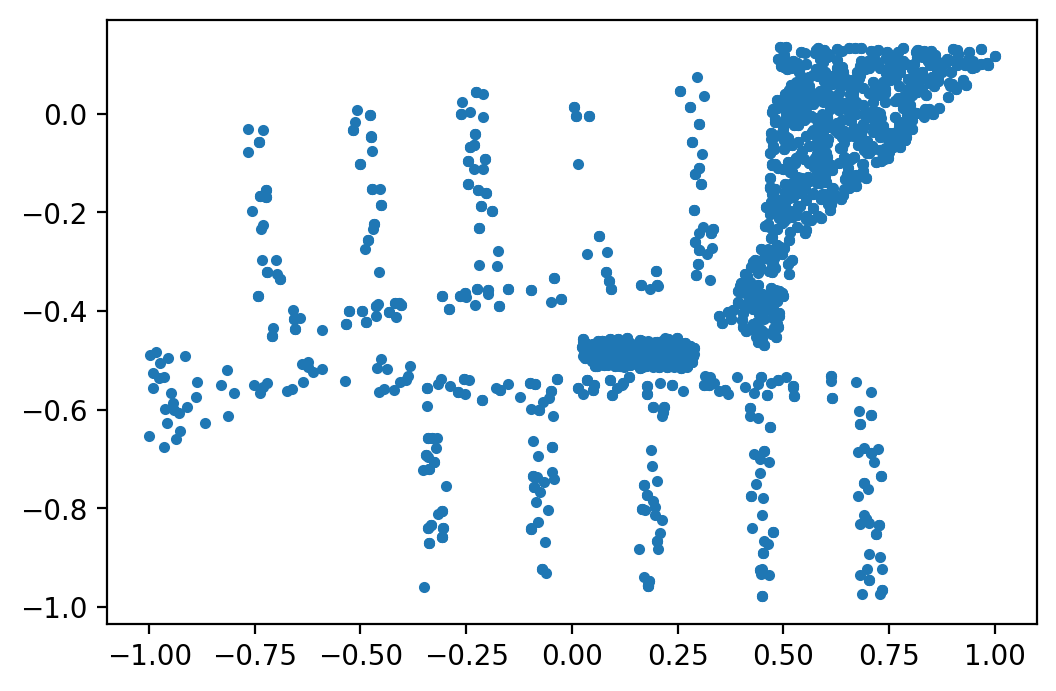

In [3]:
plt.plot(fire_train[:,0], fire_train[:,1], '.');

In [4]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(2, 256)
        self.linear2 = nn.Linear(256, latent_dims)
        self.linear3 = nn.Linear(256, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        #self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, 2)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, 1, 2, 1))

In [10]:
def train(autoencoder, fire_train, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=0.00001)
    loss_list=[]
    fire_train = torch.Tensor(fire_train)
    fire_train = torch.unsqueeze(fire_train, 1)
    print(fire_train.shape)
    
    for epoch in range(epochs):
        loss_sum=0
        total=0
        for data in fire_train:
            #data = data.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(data)
            loss = ((data - x_hat)**2).sum() + autoencoder.encoder.kl
            loss_sum += loss.item()
            total += data.size(0)
            loss.backward()
            opt.step()
        print('Epoch', epoch, 'loss', loss_sum/total)
        loss_list.append(loss_sum/total)
    plt.savefig('vae-fire.png', dpi=300, transparent=True, bbox_inches='tight')
    return autoencoder, loss_list

(3000, 2, 1)
torch.Size([3000, 1, 2, 1])
Epoch 0 loss 1.1135729408661525
Epoch 1 loss 0.9683691777785619
Epoch 2 loss 0.9602222882707914
Epoch 3 loss 0.9584982321063678
Epoch 4 loss 0.9576871925989787
Epoch 5 loss 0.957633937994639
Epoch 6 loss 0.9574177204767863
Epoch 7 loss 0.9575123503406843
Epoch 8 loss 0.9574284192323684
Epoch 9 loss 0.9575283478498459
Epoch 10 loss 0.957463244398435
Epoch 11 loss 0.9574913559357325
Epoch 12 loss 0.9574594881733258
Epoch 13 loss 0.9574294807513555
Epoch 14 loss 0.9574949140151342
Epoch 15 loss 0.9574545025428136
Epoch 16 loss 0.9574429822564126
Epoch 17 loss 0.9574231011867523
Epoch 18 loss 0.9574718937675158
Epoch 19 loss 0.9574891628225645


Text(0, 0.5, 'Loss')

<Figure size 1200x800 with 0 Axes>

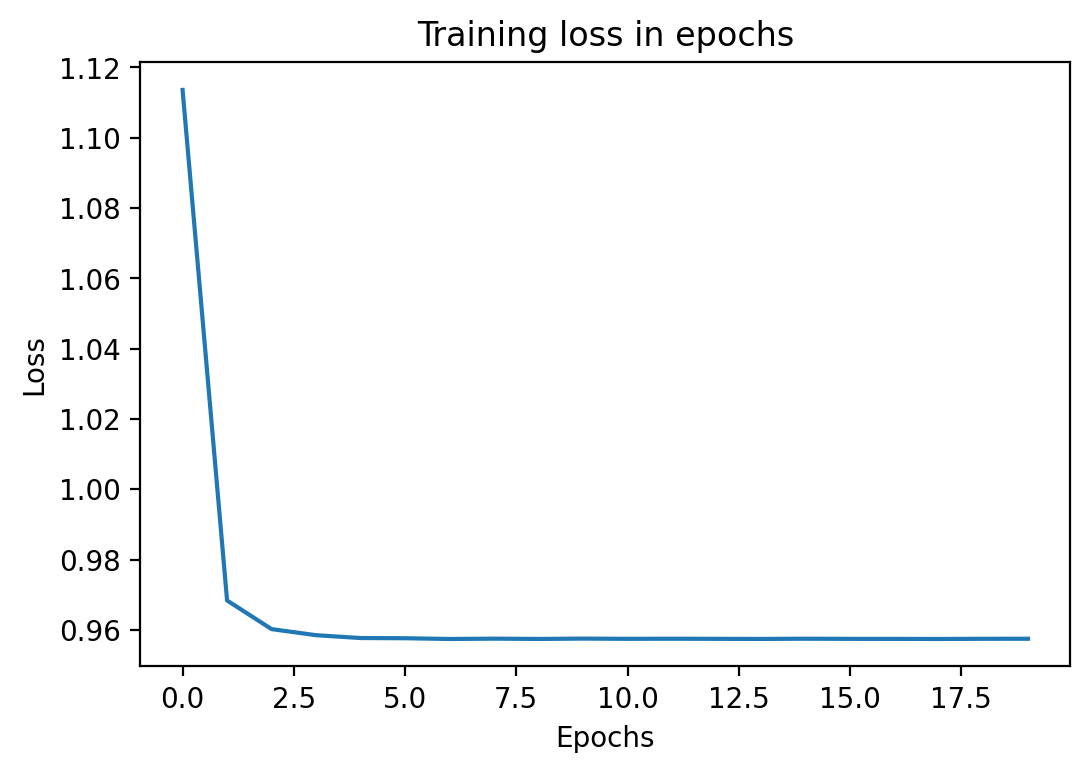

In [11]:
latent_dims = 2
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
print(fire_train.shape)
vae, loss_list = train(vae, fire_train)

plt.figure(2)
plt.plot(loss_list)
plt.title('Training loss in epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

(3000, 2, 1)


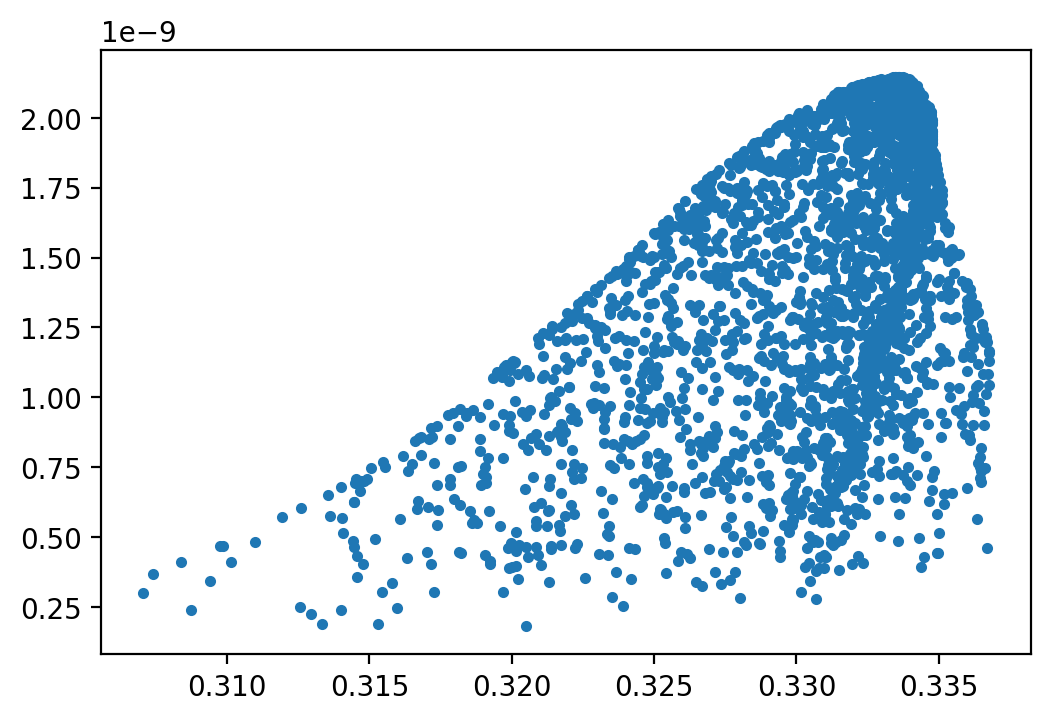

In [15]:
pred_train = vae(torch.Tensor(fire_train))
result_train=torch.squeeze(pred_train, dim=1).detach().numpy()
print(result_train.shape)
plt.plot(result_train[:,0], result_train[:,1], '.');
plt.show()

### Make a scatter plot of 1000 generated samples.

(1000, 2, 1)


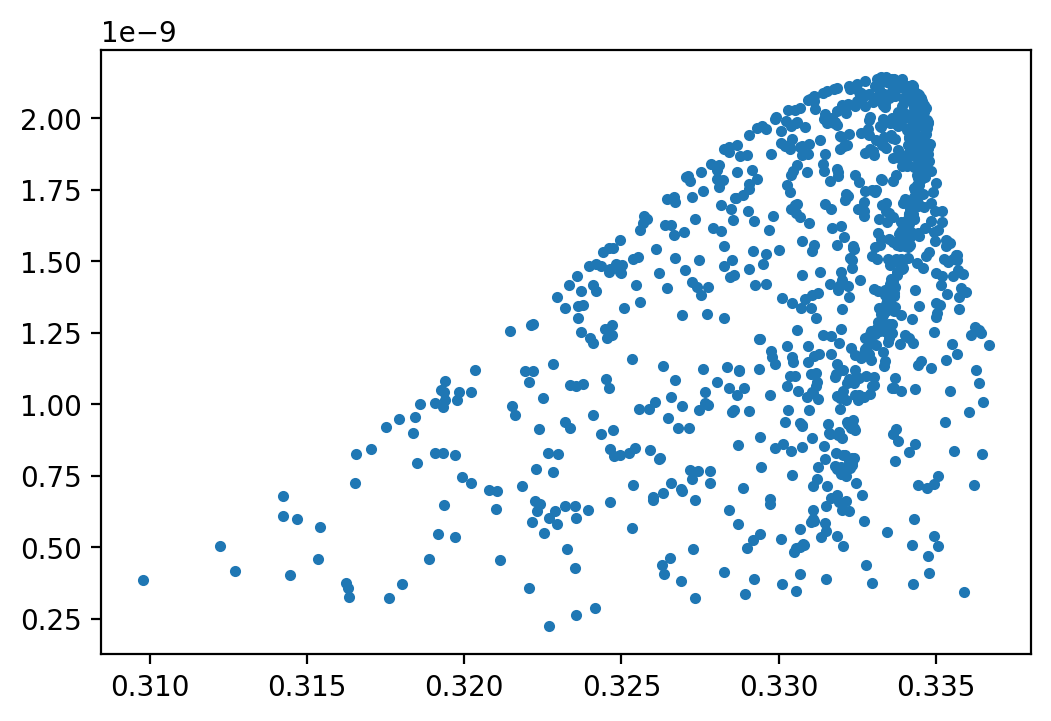

In [18]:
crowds_2000, crowds_1000 = torch.utils.data.random_split(fire_train, [2000, 1000])
pred_1000 = vae(torch.Tensor(crowds_1000))
result_1000=torch.squeeze(pred_1000, dim=1).detach().numpy()
print(result_1000.shape)
plt.plot(result_1000[:,0], result_1000[:,1], '.');
plt.show()

(600, 2, 1)


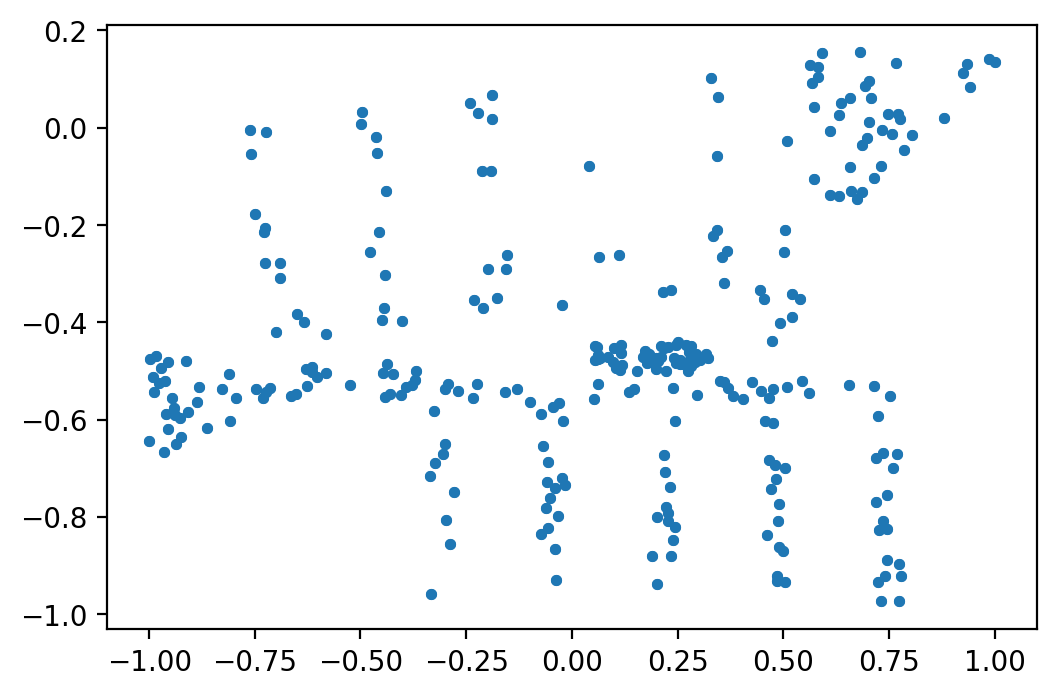

In [16]:
print(fire_test.shape)
plt.plot(fire_test[:,0], fire_test[:,1], '.');
plt.show()

### Make a scatter plot of the reconstructed test set.

(600, 2, 1)


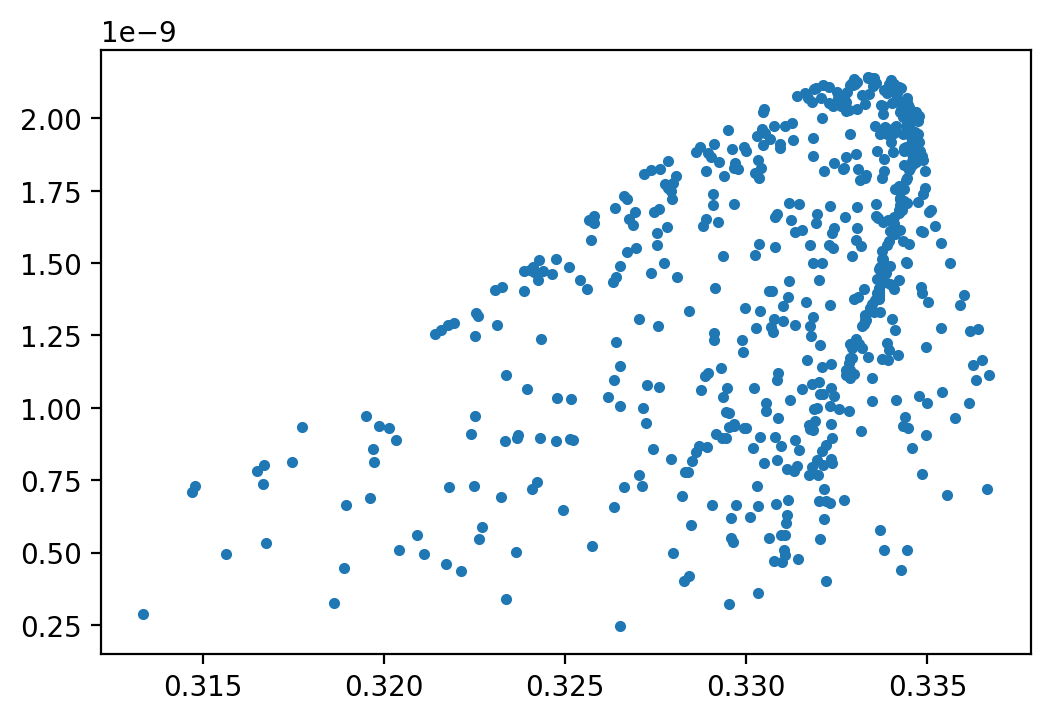

In [17]:
pred_test = vae(torch.Tensor(fire_test))
result_test=torch.squeeze(pred_test, dim=1).detach().numpy()
print(result_test.shape)
plt.plot(result_test[:,0], result_test[:,1], '.');
plt.show()

(3000, 2, 1)


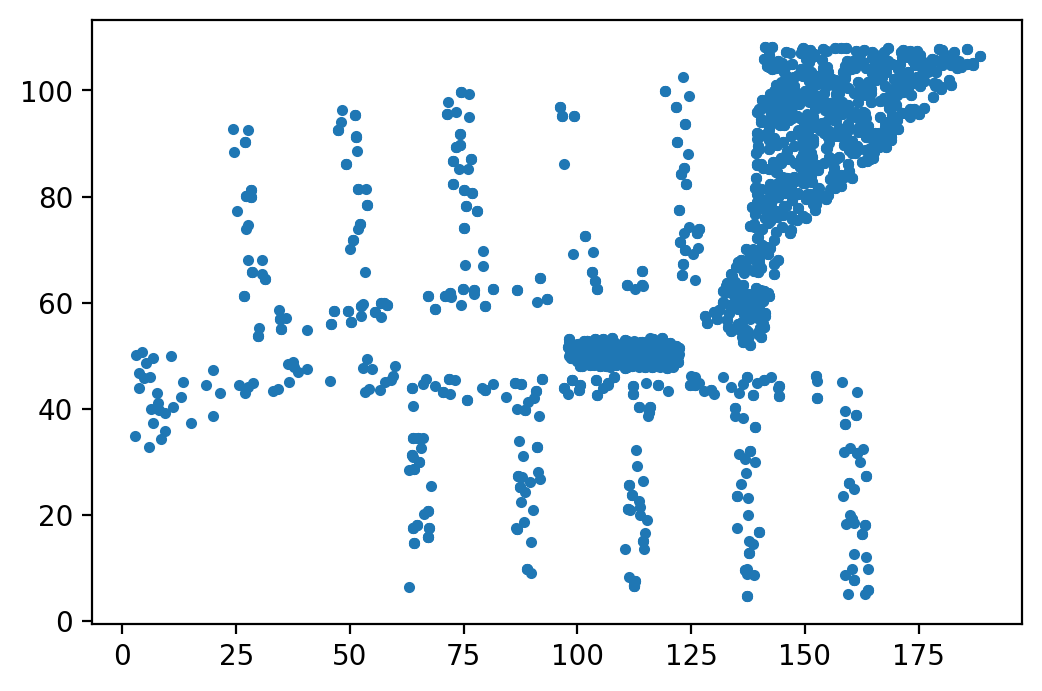

In [21]:
print(train_unsqueeze.shape)
plt.plot(train_unsqueeze[:,0], train_unsqueeze[:,1], '.');

### Generate data to estimate the critical number of people for the MI building: how many samples (people) are approximately needed to exceed the critical number at the main entrance?

In [54]:
import random
initial =2500
flag=True
#count_num=((130 < train_unsqueeze[:,0]) & (train_unsqueeze[:,0] < 150) & (50 < train_unsqueeze[:,1]) & (70 < train_unsqueeze[:,1])).sum()
#print(count_num)
#print(train_unsqueeze.shape)
while flag:
    index = torch.LongTensor(random.sample(range(3000), initial))
    #print(index)
    crowds_1 = torch.index_select(torch.Tensor(train_unsqueeze), 0, index)
    #print(crowds_1.shape)
    count_num=((130 < crowds_1[:,0]) & (crowds_1[:,0] < 150) & (50 < crowds_1[:,1]) & (70 < crowds_1[:,1])).sum()
    if count_num< 100:
        flag=False
    initial = initial - 10
print('Total number: %d'% initial)
print('Count number in region: %d' % int(count_num))

Total number: 560
Count number in region: 94
